In [16]:
SEED = 42

In [2]:
def build_vocab(model):
    emb_vectors = {}
    for n in model.wv.index_to_key:
        emb_vectors[n] = model.wv[n]
    return emb_vectors

def load_model(filename):
    model = Word2Vec.load(filename)
    emb_vectors = build_vocab(model)
    return emb_vectors, model

In [3]:
emb_vectors, model = load_model("data/word2vec/word2vec.model")
X = np.array([list(v) for k, v in emb_vectors.items()])

In [23]:
def compute_bic(kmeans, X):
    """
    Computes the BIC metric

    :param kmeans: clustering object from scikit learn
    :param X: np array of data points
    :return: BIC
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels = kmeans.labels_
    # number of clusters
    k = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    # size of data set
    N, D = X.shape
    # compute variance for all clusters beforehand
    cl_var = (1.0 / (N - k) / D) * sum([sum(distance.cdist(X[np.where(labels == i)], \
                                    [centers[0][i]],'euclidean') ** 2) for i in range(k)])
    LL = np.sum([n[i] * np.log(n[i]) -
                  n[i] * np.log(N) -
                  ((n[i] * D) / 2) * np.log(2 * np.pi * cl_var) -
                  ((D / 2)*(n[i] - 1))  for i in range(k)])
    
    d = (k - 1) + 1 + k * D
    const_term = (d / 2) * np.log(N)
    BIC = LL - const_term
    return BIC
    
def plot_metrics(n_clusters_list, metric_dictionary):
    """
    Plots metric dictionary (auxilary function)
    [Optional]
    :param n_clusters_list: List of number of clusters to explore
    :param metric_dictionary: 
    :return: 
    """
    fig = plt.figure(figsize=(12, 10), dpi=80)
    i = 1

    for metric in metric_dictionary.keys():
        plt.subplot(2, 2, i)
        plt.plot(n_clusters_list, metric_dictionary[metric], '-o')
        plt.xlabel('Number of clusters')
        plt.ylabel(metric)
        plt.xticks(n_clusters_list)
        i += 1

    
def get_heuristics_kmeans(X, n_clusters_list = range(2,10)):
    """
    Calculates heuristics for optimal number of clusters with K-Means 
    
    :param n_clusters_list: List of number of clusters to explore
    :param X: np array of data points 
    """
    silhouette_list = []
    distortion_list = []
    bic_list = []
   
    for n in tqdm(n_clusters_list):
        kmeans = KMeans(n_clusters=n, random_state=SEED)
        y_pred = kmeans.fit_predict(X)

#         silhouette = silhouette_score(X, y_pred) #Commented out because too long to compute
#         silhouette_list.append(silhouette)
        distortion = kmeans.inertia_
        distortion_list.append(distortion)
        bic = compute_bic(kmeans, X)
        bic_list.append(bic)
        
    metric_dictionary = {'BIC': bic_list,
                         'Distortion': distortion_list,
#                          'Silhouette': silhouette_list
                        }
    
    plot_metrics(n_clusters_list, metric_dictionary)

100%|██████████| 8/8 [04:18<00:00, 32.31s/it]


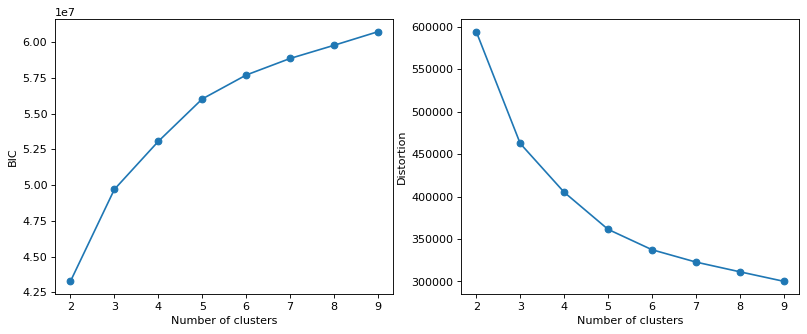

In [37]:
# n_clusters_list = range(2,10)    
# get_heuristics_kmeans(X, n_clusters_list)

In [39]:
#The cluster assignments for each embedding
clusters = KMeans(n_clusters=5, random_state=SEED).fit_predict(X)

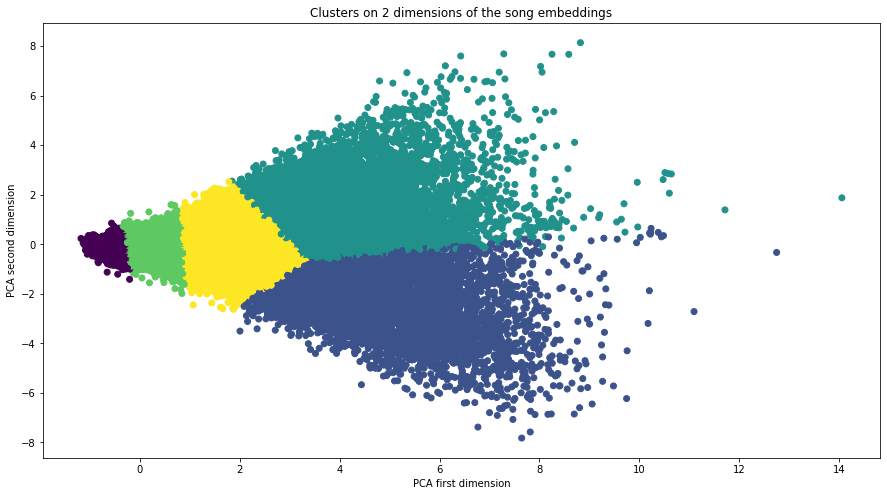

In [40]:
def plot_clusters_2D(X, clusters):
    # apply PCA
    pca = PCA(n_components=2)
    components = pca.fit_transform(X).T
    x, y = components[0], components[1]
    fig, ax = plt.subplots(figsize=(15, 8))
    plt.scatter(x=x, y=y, c=clusters)
    plt.xlabel('PCA first dimension')
    plt.ylabel('PCA second dimension')
    plt.title(f"Clusters on 2 dimensions of the song embeddings")
    plt.show()
    
# plot_clusters_2D(X, clusters)